In [1]:
import torch 
import matplotlib.pyplot as plt 
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm 
from datasets import load_dataset
import re
import torch.nn as nn
import os



# Process 

* get train and test data 
* create tokenizer from data 
* create dataset 
* create dataloader 
* load model 
* training 
* save model
* testing

In [2]:
class CSV_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.data = df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data.loc[idx, "text"]

## Prepare training data

In [3]:
def normalizer(s: str):
    s = s.lower()
    s = re.sub(r'[^a-z\s]', '', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    return s


In [4]:
ds = load_dataset("Salesforce/wikitext", "wikitext-2-v1")

In [5]:
train_ds = ds["train"]
test_ds = ds["test"]
val_ds = ds["validation"]

In [6]:
train_df = pd.DataFrame(train_ds)
test_df = pd.DataFrame(test_ds)
val_df = pd.DataFrame(val_ds)

In [7]:
train_data = pd.concat([train_df, test_df, val_df])
train_data["text"] = train_data['text'].apply(normalizer)

In [8]:
train_data.dropna(inplace= True)
train_data.drop(train_data[train_data["text"] == ""].index, inplace=True)
train_data.reset_index(inplace= True, drop= True)

In [9]:
print(len(train_data))

train_data.head() 

24529


,text
0,valkyria chronicles iii
1,senj no valkyria unk chronicles japanese lit v...
2,troops are divided into five classes scouts un...
3,unk due to these events and partly due to the ...
4,the majority of material created for previous ...


<Axes: >

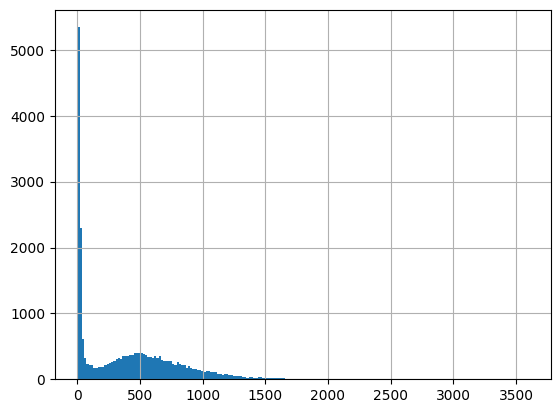

In [10]:
train_data['text'].str.len().hist(bins=200)

In [11]:
del ds, train_ds, test_ds, val_ds, train_df, test_df, val_df

## Prepare test data

In [12]:
ds = load_dataset("Salesforce/wikitext", "wikitext-103-v1", streaming= True, split= 'test')


In [13]:
test_data = pd.DataFrame(ds)
test_data["text"] = test_data["text"].apply(normalizer)
test_data.drop(test_data[test_data["text"] == ""].index, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [14]:
print(len(test_data)) 
test_data.head() 

2889


,text
0,robert boulter
1,robert boulter is an english film television a...
2,in boulter starred alongside whishaw in the pl...
3,career
4,in boulter had a guest starring role on the te...


<Axes: >

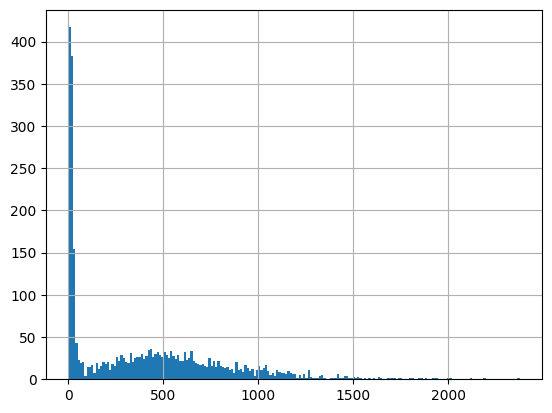

In [15]:
test_data['text'].str.len().hist(bins=200)

In [16]:
del ds

# Tokenizer

In [17]:
class Tokenizer:
    def __init__(self, data:pd.DataFrame):
        self.vocab, self.word_to_idx, self.idx_to_word = self.create_vocab(data)
        
    def create_vocab(self, df: pd.DataFrame):
        df["text"] = df["text"].apply(self.normalizer)
        vocab = set()
        for i, row in df.iterrows():
            vocab.update(row["text"].split())
        vocab = sorted(list(vocab))
        vocab.append("<pad>")
        vocab.append("<unk>")
        
        word_to_idx = {word: idx for idx, word in enumerate(vocab)}
        idx_to_word = {idx: word for idx, word in enumerate(vocab)}
        
        return vocab, word_to_idx, idx_to_word
    
    def get_vocab(self):
        return self.vocab
    
    def get_word_to_idx(self):
        return self.word_to_idx
    
    def get_idx_to_word(self):
        return self.idx_to_word
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def normalizer(self, s: str):
        s = s.lower()
        s = re.sub(r'[^a-z\s]', '', s)
        s = re.sub(r'\s+', ' ', s)
        s = s.strip()
        return s
    
    def encode(self, text):
        if isinstance(text, list):
            return [self.encode(t) for t in text]
        
        elif isinstance(text, str):
            text = self.normalizer(text)
            return [self.word_to_idx.get(word, len(self.vocab) - 1)  for word in text.split()]
        
        else:
            raise ValueError("text should be a string or a list of strings")
    
    def decode(self, idxs):
        return " ".join([self.idx_to_word[idx] for idx in idxs])
    
   

In [18]:
tokenizer = Tokenizer(train_data)

# Dataset, DataLoader

In [19]:
train_ds = CSV_Dataset(train_data)
test_ds = CSV_Dataset(test_data)

In [20]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers= 4)

In [21]:
batch = next(iter(train_loader))
print(type(batch))
print(len(batch))
batch[0]

<class 'list'>
32


'reviewers generally received this episode positively though some like ign s robert canning thought it was merely okay he gave it a score of out of and amy reiter of the los angeles times said she felt vaguely unk and that the episode lacked emotional resonance in contrast the av club s todd vanderwerff gave the episode a b and called it a marked improvement over the season premiere and complimented the way it gave nearly all of the storylines an emotional core anthony benigno of the unk times characterized it as one of the unk best made most well acted and entertaining hours from glee in a very long time and buddytv s john kubicek said that it was quintessential glee and that the show is once again a magical fabulous unicorn bobby unk of the houston chronicle was charmed moved and excited for what s to come'

# Model

In [22]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:

training_config = {"vocab_size": tokenizer.get_vocab_size(), 
                "embedding_dim": 100, 
                "hidden_dim": 256, 
                "learning_rate": 1e-3,
                "epochs": 30,
                "batch_size": 256,
                "window_size": 5,
                "device": device}

In [24]:
!nvidia-smi

Thu Oct 10 15:35:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
class SimpleNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, window_size: int):
        """ 
        Intialize the model 
        
        Input:
        vocab_size: int, input size of the model since each word is a one-hot vector. Yhis is alos the output size of the model
        embedding_dim: int, the dimension of the word embedding
        hidden_dim: int, the dimension of the hidden layer
        window_size: int, the size of the window to consider the context of the word
        """
        super(SimpleNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.window_size = window_size
        
        self.embedding = nn.Embedding(num_embeddings= vocab_size, embedding_dim=embedding_dim) 
        self.relu1 = nn.LeakyReLU(negative_slope=0.15)
        self.flaten = nn.Flatten()
        self.fc1 =nn.Linear(in_features=embedding_dim*window_size, out_features=hidden_dim)
        self.relu2 = nn.LeakyReLU(negative_slope=0.15)
        self.fc2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.relu3 = nn.LeakyReLU(negative_slope=0.15)
        self.fc3= nn.Linear(in_features=hidden_dim, out_features= vocab_size)
        
    def forward(self, x):  # x: (batch_size, window_size), dtype = torch.int
        # print(x.shape)
        x = self.embedding(x)   # x: (batch_size, window_size, embedding_dim)
        x = self.relu1(x)   
        x = self.flaten(x)   # x: (batch_size, window_size*embedding_dim)
        x = self.fc1(x)     # x: (batch_size, hidden_dim)        
        x = self.relu2(x)   
        x = self.fc2(x)     # x: (batch_size, hidden_dim)
        x = self.relu3(x)
        x = self.fc3(x)     # x: (batch_size, vocab_size)
        # x = torch.softmax(x, dim=1)
        return x

In [26]:
model = SimpleNN(vocab_size=training_config["vocab_size"], 
                 embedding_dim=training_config["embedding_dim"], 
                 hidden_dim=training_config["hidden_dim"], 
                 window_size=training_config["window_size"])

# Training

In [27]:
def get_Loss_func():
    return torch.nn.CrossEntropyLoss()

def generate_data(batch: list[str], tokenizer= None, config: dict= None):
    data = tokenizer.encode(batch)
    inputs = []
    targets = [] 
    for sample in data:
        for idx in range(len(sample) - config["window_size"]):
            inputs.append(sample[idx:idx+config["window_size"]])
            targets.append(sample[idx+config["window_size"]])
    return torch.tensor(inputs, dtype= torch.long), torch.tensor(targets, dtype= torch.long)

def model_step(batch, model, loss_func, config: dict):
    _input, target = batch
    _input = _input.to(config['device'])
    target = target.to(config['device'])
    outputs = model(_input)
    loss = loss_func(outputs, target)
    
    del _input, target, outputs
    return loss

def optimizer_step(optimizer, loss):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def train_epoch(model, train_loader, loss_func, optimizer, tokenizer, config: dict, epoch):
    model.train()
    pbar = tqdm(train_loader)
    total, total_loss = 0, 0
    for batch in pbar:
        inputs, targets = generate_data(batch, tokenizer, config)
        for idx in range(0, len(inputs) , config["batch_size"]):
            x = inputs[idx:idx+config["batch_size"]]
            y = targets[idx:idx+config["batch_size"]]
            loss= model_step((x, y), model, loss_func, config= config)
            optimizer_step(optimizer, loss)

            # total += len(y)
            total += 1
            total_loss += loss.item()
        pbar.set_description(f"epoch = {epoch}, train/loss = {total_loss/total:.3f}")
            
    return (total_loss / total)    #loss


def plot_training_history(train_loss_history):
    plt.figure(figsize=(8, 8))
    plt.plot(train_loss_history, label='Training Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.show()

def train(model, train_loader, tokenizer = None, plot_res = True, config: dict = None):
    train_loss_history = []
    loss_func = get_Loss_func()
    optimizer = torch.optim.Adam(model.parameters(), config["learning_rate"])
    model.to(config['device'])
    for epoch in range(config["epochs"]):
        ## train loop
        train_loss = train_epoch(model, train_loader, loss_func, optimizer, tokenizer, config, epoch)
        train_loss_history.append(train_loss)
            
    if(plot_res):
        plot_training_history(train_loss_history)
    return model, train_loss_history

def save_weight(model, output_file):
    print("save model to", output_file)
    torch.save(model.state_dict(), output_file)
    


In [28]:
print(model)

SimpleNN(
  (embedding): Embedding(27183, 100)
  (relu1): LeakyReLU(negative_slope=0.15)
  (flaten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=500, out_features=256, bias=True)
  (relu2): LeakyReLU(negative_slope=0.15)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu3): LeakyReLU(negative_slope=0.15)
  (fc3): Linear(in_features=256, out_features=27183, bias=True)
)


In [29]:
#calculate total params 
total_params = sum(p.numel() for p in model.parameters())
total_params

9898379

epoch = 29, train/loss = 3.835: 100%|██████████| 767/767 [00:52<00:00, 14.56it/s]


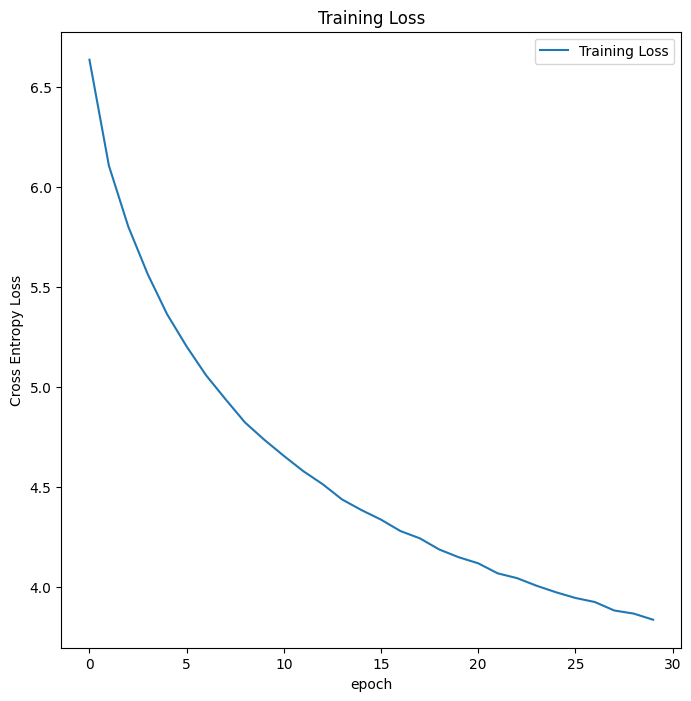

In [30]:
model, training_history = train(model = model, train_loader= train_loader, tokenizer = tokenizer, config= training_config)


In [31]:
save_weight(model, "ckpt.pth")

save model to ckpt.pth


In [36]:
import numpy as np

# Evaluate

In [55]:
def evaluate(model, test_loader, tokenizer, config):
    loss_func = get_Loss_func()
    model.eval()
    total, total_loss = 0, 0
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, targets = generate_data(batch, tokenizer, config)
            for idx in range(0, len(inputs) , config["batch_size"]):
                x = inputs[idx:idx+config["batch_size"]]
                y = targets[idx:idx+config["batch_size"]]
                loss= model_step((x, y), model, loss_func, config= config)
                
                total += 2
                total_loss += loss.item()
    res_loss = total_loss / total
    perplexity = np.exp(res_loss)
    return perplexity, res_loss

In [56]:
perplex_score, test_loss = evaluate(model, test_loader, tokenizer, training_config)

100%|██████████| 91/91 [00:01<00:00, 48.76it/s]


In [57]:
perplex_score

38.913835565572576

In [58]:
test_loss

3.6613498574549292

# Inference

In [84]:
def predict(net: nn.Module, tokenizer, text: str, window_size: int):
    text_id = tokenizer.encode(text)
    generated_text = [] 
    if len(text_id) < window_size:
        text_id = tokenizer.encode('<pad>') * (window_size - len(text_id)) + text_id
    for i in range(100):
        inputs = text_id + generated_text
        inputs = inputs[-window_size:]
        # print(inputs)
        inputs = torch.tensor(inputs, dtype= torch.long, device= training_config['device']).unsqueeze(0)
        prob = net(inputs)
        prob = torch.softmax(prob, dim=1)
        next_word_id = torch.argmax(prob).item()
        generated_text.append(next_word_id)
        
    return text + " " + tokenizer.decode(generated_text)

In [85]:
test_text = "TBD"
print(predict(model, tokenizer, test_text, 5))

TBD as gordon was arrested in the united states and the jamaican version of the song was released on april as a digital download in the united kingdom the first versions of the song was released on april as a digital download in the united kingdom the first versions of the song was released on april as a digital download in the united kingdom the first versions of the song was released on april as a digital download in the united kingdom the first versions of the song was released on april as a digital download in the united kingdom the
